In [24]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel 
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi

# plotting libraries
import pylab as py
import aplpy
import matplotlib.pyplot as plt
from matplotlib import colors

# libraries for machine learning
from sklearn import decomposition

# random libraries
import time
import math
import warnings

plt.style.use(astropy_mpl_style)

In [4]:
drpall = fits.open('drpall-v2_1_2.fits')
drpall_data = drpall[1].data

nsa = fits.open('nsa_v1_0_1.fits')
nsa_data = nsa[1].data

NO_GALAXY = 40

nsa_names = nsa_data['IAUNAME'][0:NO_GALAXY]
nsa_ra = nsa_data['RA'][0:NO_GALAXY]
nsa_dec = nsa_data['DEC'][0:NO_GALAXY]
nsa_petroth50 = nsa_data['PETRO_TH50'][0:NO_GALAXY]
nsa_petroth90 = nsa_data['PETRO_TH90'][0:NO_GALAXY]
nsa_zdist = nsa_data['zdist'][0:NO_GALAXY]
nsa_ang = nsa_data['SERSIC_PHI'][0:NO_GALAXY]

# print(nsa[1].header)




In [7]:
def apparent_angle(petroth90, zdist):
    delta = 2*math.atan(petroth90/zdist)
    return delta

standard_aa = apparent_angle(nsa_petroth90[0], nsa_zdist[0])
print(standard_aa)


3.137634711702541


In [8]:
nsa_galaxy_images = {}
for name, ra, dec, petroth90, zdist in zip(nsa_names, nsa_ra, nsa_dec, nsa_petroth90, nsa_zdist):
    radec = str(ra) + ',' + str(dec)
    
    aa = apparent_angle(petroth90, zdist)
    no_pixels = aa/standard_aa * 140
    
    print(name)
    print(petroth90, zdist)
    
    
    img = SkyView.get_images(position=radec, survey=['SDSSi'], pixels=int(no_pixels),)
    original_img_data = img[0][0].data.copy()
    nsa_galaxy_images[name] = original_img_data
    result = cv2.imwrite('original_images/{}.jpg'.format(name), original_img_data)
    if result == True:
        print('Image saved successfully')
    else:
        print('Failed to save image')


J094651.40-010228.5
10.453795 0.020687785
Image saved successfully
J094630.85-004554.5
6.7219906 0.06403577
Image saved successfully
J094631.59-005917.7
5.1779103 0.052030597
Image saved successfully
J094744.18-004013.4
9.177605 0.1206503
Image saved successfully
J094751.74-003242.0
10.253274 0.05536205
Image saved successfully
J094751.24-004533.5
4.8975 0.09646486
Image saved successfully
J094726.35-004832.0
7.95873 0.125968
Image saved successfully
J094622.25-004536.9
7.6296973 0.06433888
Image saved successfully
J094654.77-003324.5
37.558548 0.088694006
Image saved successfully
J094625.73-011426.7
14.22231 0.08997462
Image saved successfully
J094844.82-002937.7
18.740425 0.08969857
Image saved successfully
J094749.45-002032.2
14.762701 0.13406454
Image saved successfully
J094842.33-002114.5
24.108818 0.0068420386
Image saved successfully
J094859.52-000208.5
6.6866083 0.08358431
Image saved successfully
J094740.82-001823.2
7.259929 0.13086501
Image saved successfully
J094919.08+00014

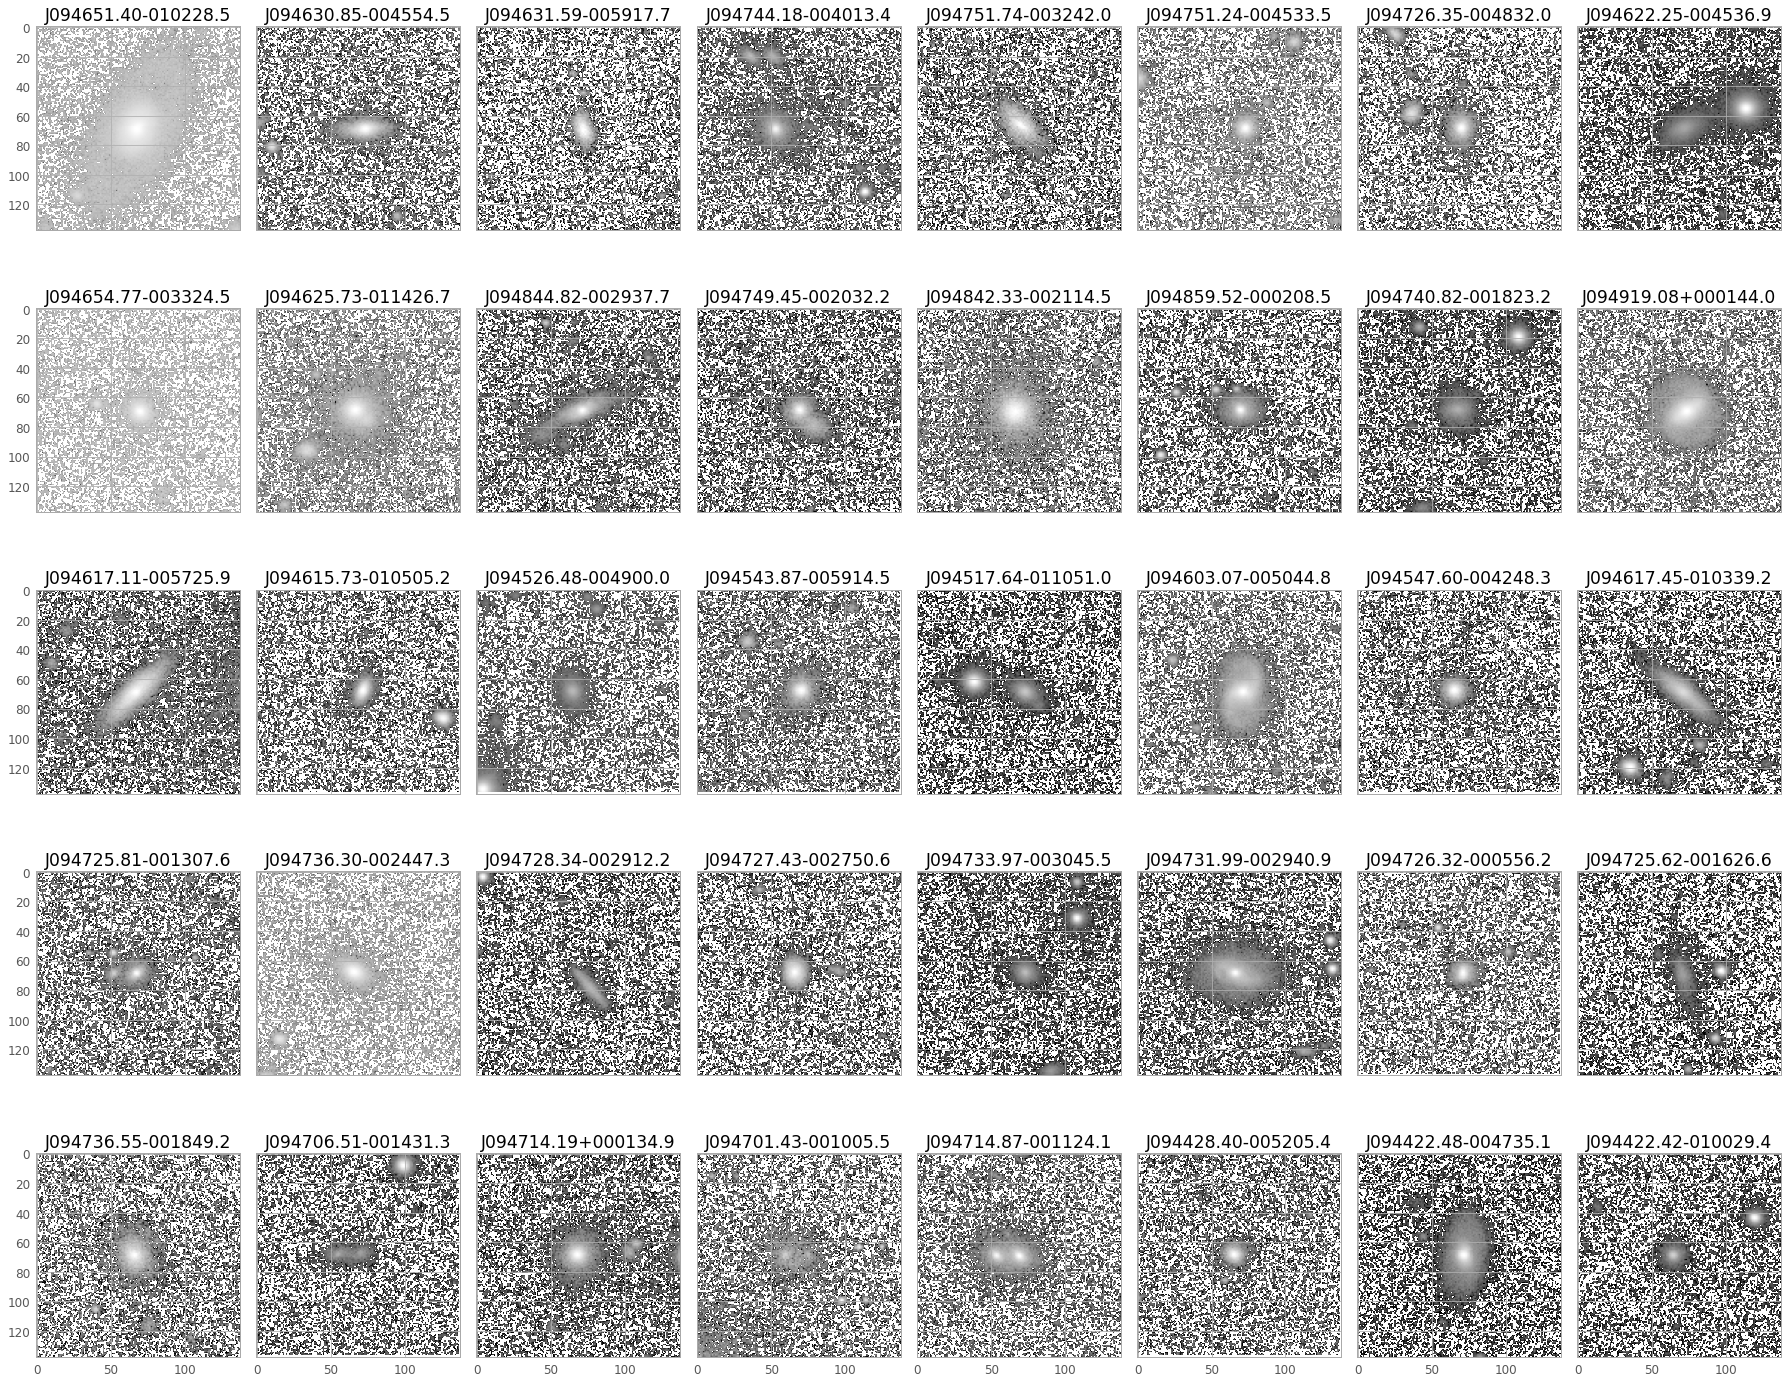

In [32]:
fig, axes = plt.subplots(5, 8, figsize=(25, 20), sharex=True, sharey=True)
ax = axes.ravel()
i = 0

for galaxy, original_img_data in nsa_galaxy_images.items():
#     norm = colors.LogNorm(original_img_data.mean() + 0.5 * original_img_data.std(), original_img_data.max(), clip='True')
    norm = colors.LogNorm()
    ax[i].set_title(galaxy)
    ax[i].imshow(original_img_data, norm=norm, cmap='gray')
    i += 1
    

plt.tight_layout()
plt.show()

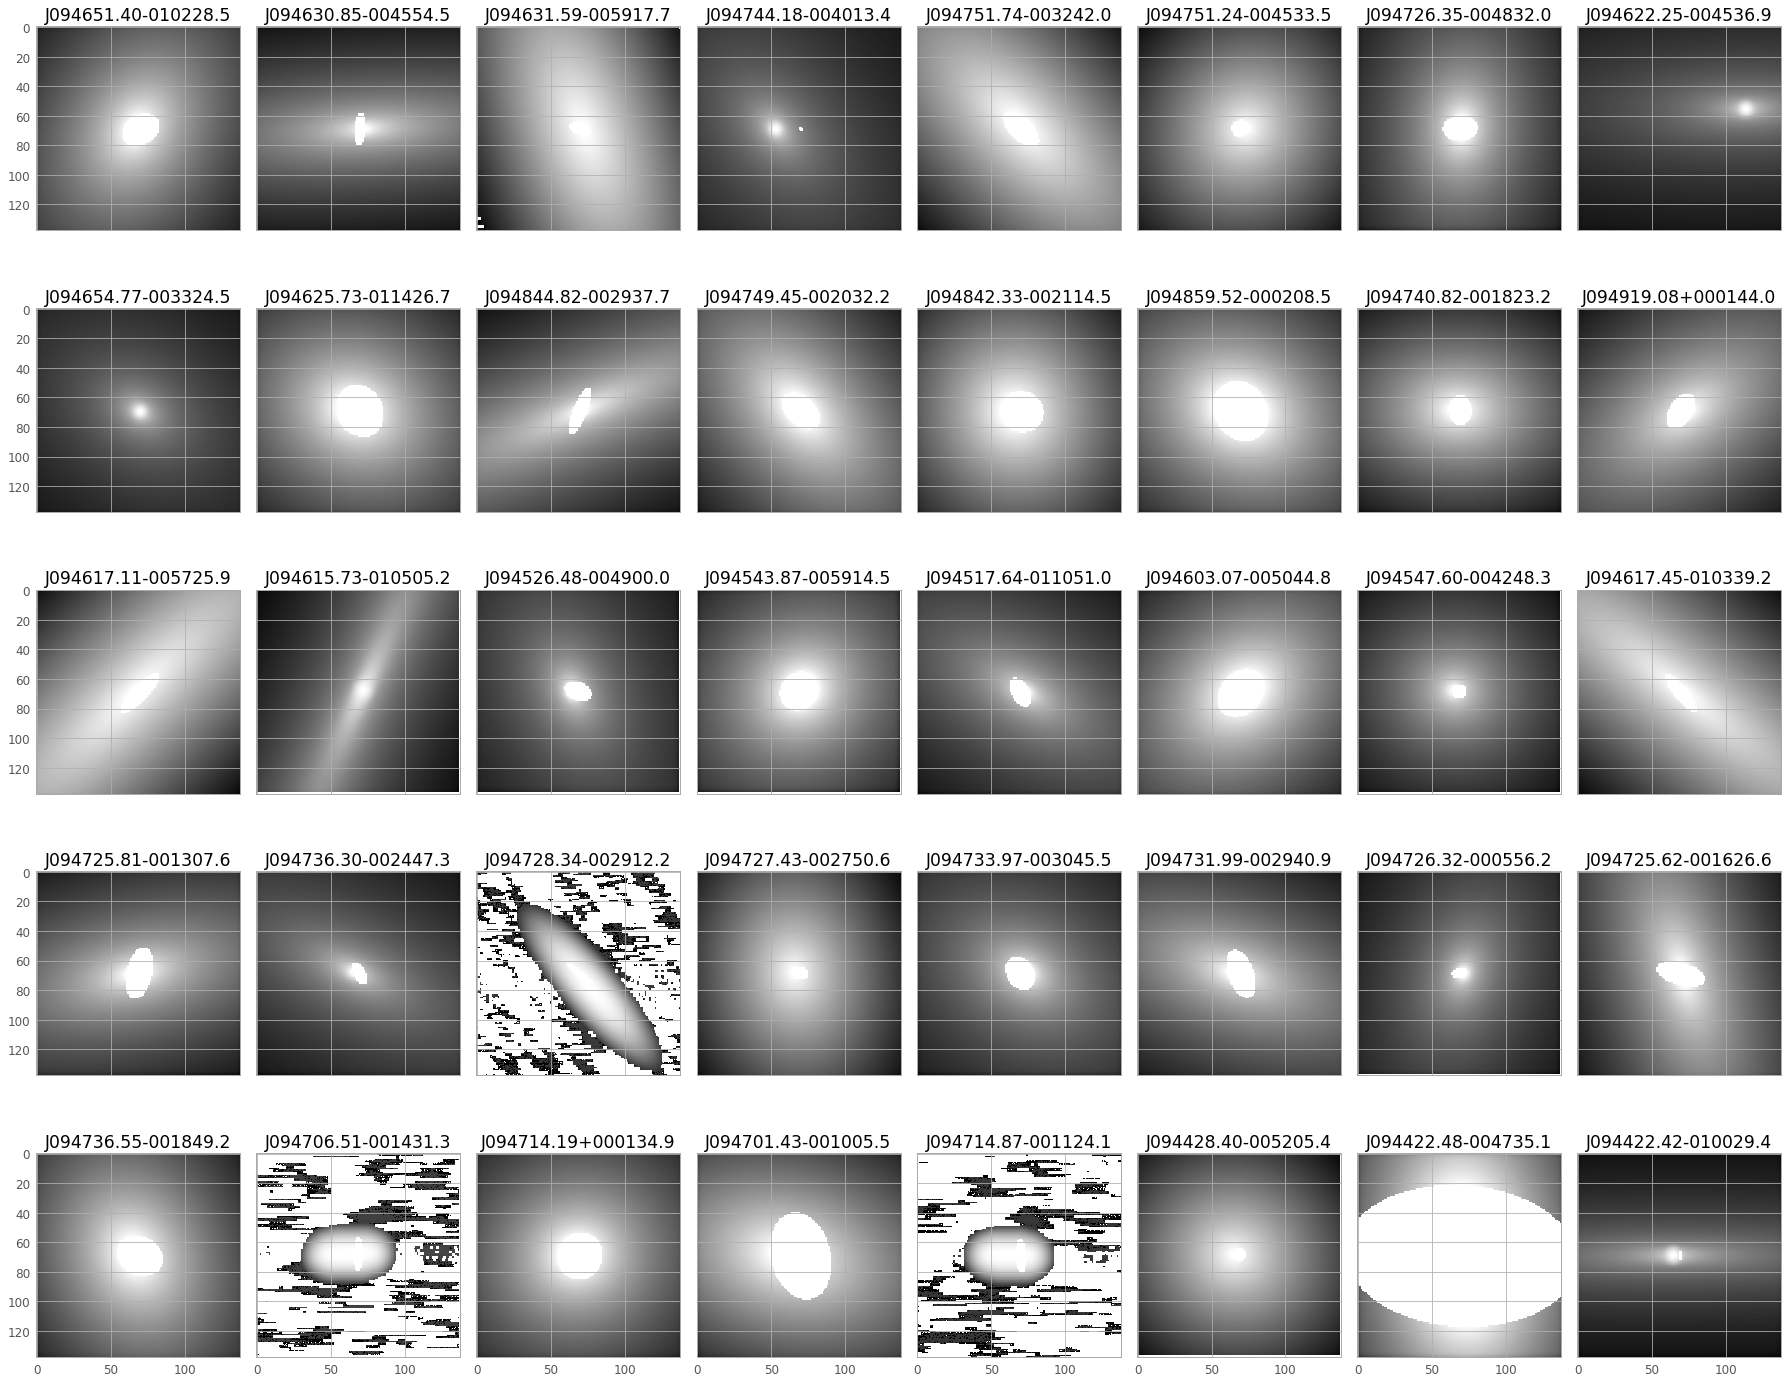

In [51]:
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(5, 8, figsize=(25, 20), sharex=True, sharey=True)
ax = axes.ravel()
i = 0

from skimage import transform
import skimage
import random
from math import cos, sin

gain = 10000 # editable parameter

#PSF 
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')


for galaxy, original_img_data in nsa_galaxy_images.items():
    mean = np.nanmean(original_img_data)
    std = np.nanstd(original_img_data)
    
    
    
    image = original_img_data.copy()
    norm = colors.LogNorm()
    
    threshold = photutils.detect_threshold(image, 1.5)
    npixels = 5  # minimum number of connected pixels
    segm = photutils.detect_sources(image, threshold, npixels)


    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label    
    
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = segmap_float > 0.5

#     rotated_image = transform.rotate(original_img_data.byteswap().newbyteorder(), float(nsa_ang[i]),
#                                     mode='constant', cval=np.NaN)
   
#     for u in range(rotated_image.shape[0]):
#         for v in range(rotated_image.shape[1]):
#             if bool(np.isnan(rotated_image[u][v])):
#                 rotated_image[u][v] = random.gauss(mean, std)

    source_morphs = statmorph.source_morphology(image, segmap, gain=gain, psf=psf)

    morph = source_morphs[0]
    
    ny, nx = image.shape
    y, x = np.mgrid[0:ny, 0:nx]
    fitted_model = statmorph.ConvolvedSersic2D(amplitude=morph.sersic_amplitude,
                                                r_eff=morph.sersic_rhalf,
                                                n=morph.sersic_n,
                                                x_0=morph.sersic_xc,
                                                y_0=morph.sersic_yc,
                                                ellip=morph.sersic_ellip,
                                                theta=morph.sersic_theta)
    
    fitted_model.set_psf(psf)  # required when using ConvolvedSersic2D
    image_model = fitted_model(x, y)
    
    theta = morph.sersic_theta
    rmaj = morph.sersic_rhalf
    ellip = morph.sersic_ellip
    rmin = rmaj - (rmaj * ellip)
    
    for ii in range(image.shape[0]):
        for jj in range(image.shape[1]):
            x = ii - image_model.shape[0]/2
            y = jj - image_model.shape[1]/2
            if ((x*cos(theta)+y*sin(theta))/rmaj)**2 + ((x*sin(theta)-y*cos(theta))/rmin)**2 < 1:
                image_model[ii][jj] = np.NaN
    
    ax[i].set_title(galaxy)
    ax[i].imshow(image_model, cmap='gray', norm=norm)
    i += 1
    
    
plt.tight_layout()
plt.show()

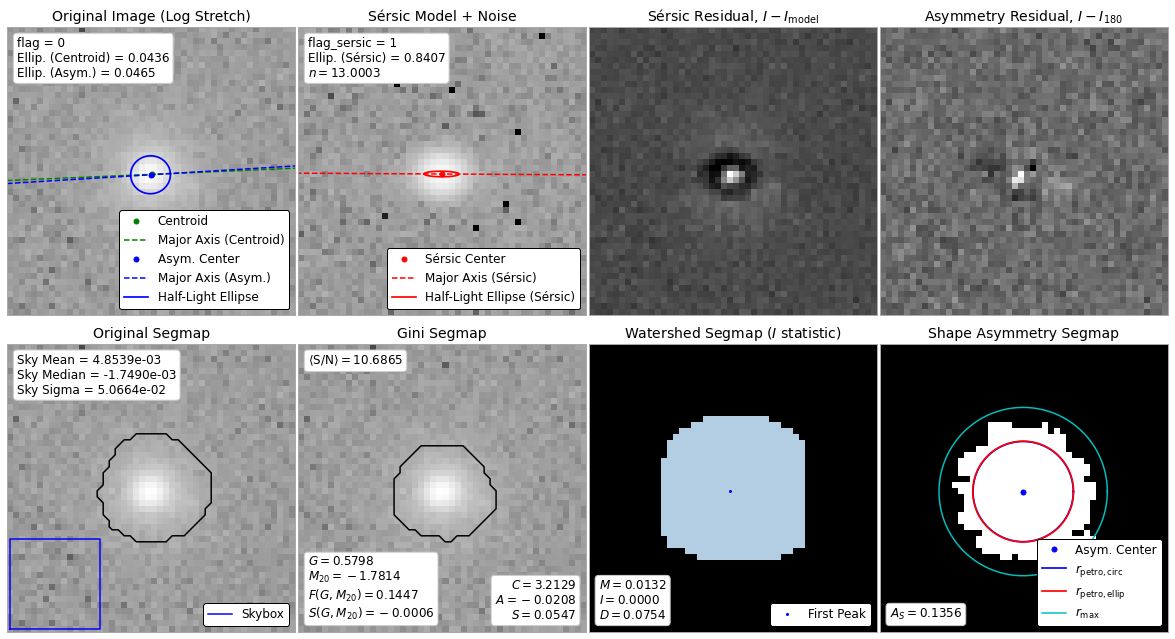

In [44]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

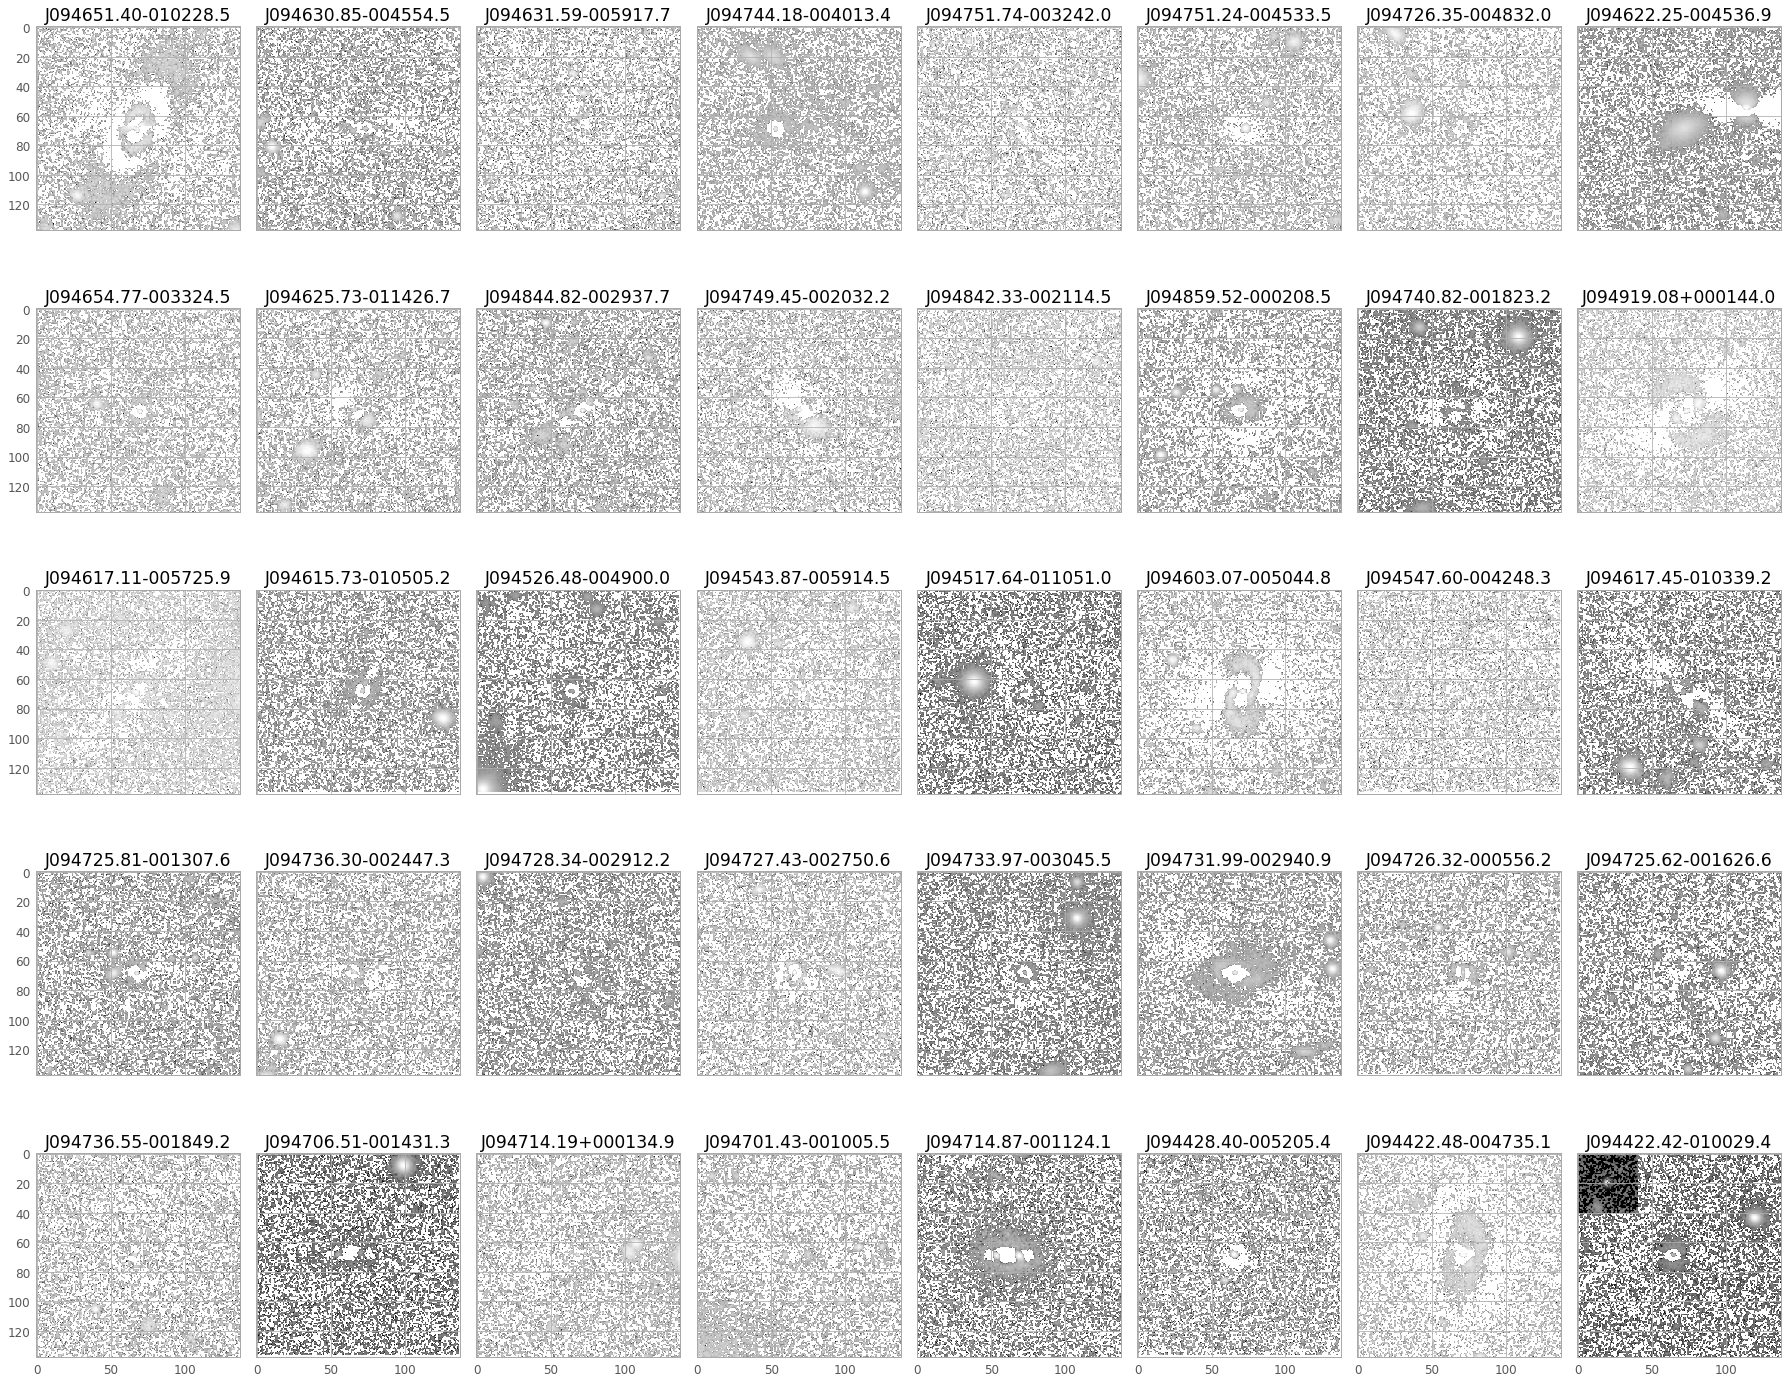

In [37]:
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(5, 8, figsize=(25, 20), sharex=True, sharey=True)
ax = axes.ravel()
i = 0

from skimage import transform
import skimage
import random


gain = 10000 # editable parameter

#PSF 
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')


for galaxy, original_img_data in nsa_galaxy_images.items():
    mean = np.nanmean(original_img_data)
    std = np.nanstd(original_img_data)
    
    
    
    image = original_img_data.copy()
    norm = colors.LogNorm()
    
    threshold = photutils.detect_threshold(image, 1.5)
    npixels = 5  # minimum number of connected pixels
    segm = photutils.detect_sources(image, threshold, npixels)


    label = np.argmax(segm.areas) + 1
    segmap = segm.data == label    
    
    segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
    segmap = segmap_float > 0.5

#     rotated_image = transform.rotate(original_img_data.byteswap().newbyteorder(), float(nsa_ang[i]),
#                                     mode='constant', cval=np.NaN)
   
#     for u in range(rotated_image.shape[0]):
#         for v in range(rotated_image.shape[1]):
#             if bool(np.isnan(rotated_image[u][v])):
#                 rotated_image[u][v] = random.gauss(mean, std)

    source_morphs = statmorph.source_morphology(image, segmap, gain=gain, psf=psf)

    morph = source_morphs[0]
    
    ny, nx = image.shape
    y, x = np.mgrid[0:ny, 0:nx]
    fitted_model = statmorph.ConvolvedSersic2D(amplitude=morph.sersic_amplitude,
                                                r_eff=morph.sersic_rhalf,
                                                n=morph.sersic_n,
                                                x_0=morph.sersic_xc,
                                                y_0=morph.sersic_yc,
                                                ellip=morph.sersic_ellip,
                                                theta=morph.sersic_theta)
    
    fitted_model.set_psf(psf)  # required when using ConvolvedSersic2D
    image_model = fitted_model(x, y)

    ax[i].set_title(galaxy)
    ax[i].imshow(image_model, cmap='gray', norm=norm)
    i += 1
    
    
plt.tight_layout()
plt.show()